In [ ]:
# ====================================================================
# FULL KNAPSACK CIRCUIT (WEIGHTS & VALUES) - FINAL CORRECTED VERSION
# ====================================================================

from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, transpile)
from qiskit_aer import Aer
from qiskit.circuit.library.arithmetic import DraperQFTAdder
from qiskit.circuit.library import QFT
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import math
import numpy as np

# ──────────  DATA  ─────────────────────────────────────────────
weights = [2, 3, 4, 5, 9]  # Item weights
values =  [3, 4, 5, 6, 10] # Item values
capacity = 14              # Knapsack capacity
n_items = len(weights)
# Use enough bits to represent the max possible sum
n_bits = math.ceil(math.log2(sum(weights))) + 1

# ──────────  HELPER FUNCTION FOR QFT COMPARATOR ─────────────────
def qft_add_or_subtract(qc, reg_a, reg_b, subtract=False):
    """Adds or subtracts reg_b from reg_a using QFT-based controlled phase rotations."""
    sign = -1 if subtract else 1
    for i in range(len(reg_b)):
        for j in range(i, len(reg_a)):
            angle = sign * math.pi / (2**(j - i))
            qc.cp(angle, reg_b[i], reg_a[j])

# ──────────  CORRECT QFT COMPARATOR (Checks for A < B) ────────────
def create_comparator_circuit(num_bits: int):
    """
    Creates a comparator circuit that sets an output flag to 1 if A < B.
    It is self-contained and uncomputes its operations, leaving A and B unchanged.
    """
    a_reg = QuantumRegister(num_bits, 'a')
    b_reg = QuantumRegister(num_bits, 'b')
    out_reg = QuantumRegister(1, 'out')
    comp_qc = QuantumCircuit(a_reg, b_reg, out_reg, name='Comparator(A<B)')

    # 1. Subtract B from A (A-B), result stored in a_reg
    comp_qc.append(QFT(num_bits, do_swaps=False), a_reg)
    qft_add_or_subtract(comp_qc, a_reg, b_reg, subtract=True)
    comp_qc.append(QFT(num_bits, do_swaps=False).inverse(), a_reg)

    # 2. Check the sign bit (MSB). If A-B is negative, MSB is 1, so A < B.
    comp_qc.cx(a_reg[num_bits - 1], out_reg[0])

    # 3. Uncompute the subtraction by adding B back to a_reg to restore it
    comp_qc.append(QFT(num_bits, do_swaps=False), a_reg)
    qft_add_or_subtract(comp_qc, a_reg, b_reg, subtract=False)
    comp_qc.append(QFT(num_bits, do_swaps=False).inverse(), a_reg)

    return comp_qc.to_instruction()

# ──────────  REGISTERS  ────────────────────────────────────────
x = QuantumRegister(n_items, 'x')
Wt_Vt = QuantumRegister(n_bits, 'Wt_Vt')
sum_reg = QuantumRegister(n_bits, 'sum')
carry = QuantumRegister(1, 'carry')
comp_reg = QuantumRegister(n_bits, 'comp')
weight_flag = QuantumRegister(1, 'w_flag')
value_flag = QuantumRegister(1, 'v_flag')
validity_flag = QuantumRegister(1, 'valid_flag')

c_sel = ClassicalRegister(n_items, 'c_sel')
c_val_sum = ClassicalRegister(n_bits, 'c_val_sum')
c_w_flag = ClassicalRegister(1, 'c_w_flag')
c_v_flag = ClassicalRegister(1, 'c_v_flag')
c_valid_flag = ClassicalRegister(1, 'c_valid_flag')

qc = QuantumCircuit(x, Wt_Vt, sum_reg, carry, comp_reg, weight_flag, value_flag, validity_flag,
                    c_sel, c_val_sum, c_w_flag, c_v_flag, c_valid_flag)

# ────────── 0) Initialise selection register ───────────────────
qc.x(x[0])
qc.h(x[1:])
qc.barrier(label="0 – init |x⟩")

# ──────────  Define Gates  ─────────────────────────────────────
# Base adder/subtractor gates
adder = DraperQFTAdder(n_bits, kind='half', name='adder').decompose()
subtractor = adder.inverse()
subtractor.name = "subtractor"

# --- Create Controlled versions of the gates ---
controlled_adder = adder.control(1, ctrl_state='1')
controlled_subtractor = subtractor.control(1, ctrl_state='1')
comparator_gate = create_comparator_circuit(n_bits)

# ==============================================================
# STAGE 1: WEIGHT FEASIBILITY (TotalWeight <= Capacity)
# ==============================================================
# 1a) Load capacity into comp_reg
cap_bits = format(capacity, f'0{n_bits}b')[::-1]
for i, bit in enumerate(cap_bits):
    if bit == '1': qc.x(comp_reg[i])
qc.barrier(label="1a – load |capacity⟩")

# 1b) Conditionally sum weights into sum_reg
for idx, w_val in enumerate(weights):
    # Load weight into Wt_Vt, controlled by x[idx]
    w_bits = format(w_val, f'0{n_bits}b')[::-1]
    for j, bit in enumerate(w_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
    
    # Add to sum, controlled by x[idx]
    qc.append(controlled_adder, [x[idx]] + Wt_Vt[:] + sum_reg[:] + carry[:])
    
    # Unload weight (to reset Wt_Vt for next iteration)
    for j, bit in enumerate(w_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
    qc.reset(carry)
qc.barrier(label="1b – add weights")

# 1c) Compare: Is TotalWeight <= Capacity?
qc.append(comparator_gate, comp_reg[:] + sum_reg[:] + weight_flag[:])
qc.x(weight_flag) # Comparator gives 1 for A<B. We want NOT(Cap<Wt), so we flip.
qc.barrier(label="1c – compare (Wt<=Cap)")

# ==============================================================
# STAGE 2: UNCOMPUTATION
# ==============================================================
# 2a) Conditionally subtract weights to reset sum_reg
for idx, w_val in enumerate(weights):
    w_bits = format(w_val, f'0{n_bits}b')[::-1]
    for j, bit in enumerate(w_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
    
    qc.append(controlled_subtractor, [x[idx]] + Wt_Vt[:] + sum_reg[:] + carry[:])
    
    for j, bit in enumerate(w_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
    qc.reset(carry)
qc.barrier(label="2a – subtract weights")

# 2b) Reset comp_reg by un-loading capacity
for i, bit in enumerate(cap_bits):
    if bit == '1': qc.x(comp_reg[i])
qc.barrier(label="2b – unload |capacity⟩")

# ==============================================================
# STAGE 3: VALUE FEASIBILITY (TotalValue > 0)
# ==============================================================
# 3a) Conditionally sum values into sum_reg
for idx, v_val in enumerate(values):
    v_bits = format(v_val, f'0{n_bits}b')[::-1]
    for j, bit in enumerate(v_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
        
    qc.append(controlled_adder, [x[idx]] + Wt_Vt[:] + sum_reg[:] + carry[:])
    
    for j, bit in enumerate(v_bits):
        if bit == '1': qc.cx(x[idx], Wt_Vt[j])
    qc.reset(carry)
qc.barrier(label="3a – add values")

# 3b) Compare: Is TotalValue > 0? (i.e., 0 < TotalValue)
qc.append(comparator_gate, comp_reg[:] + sum_reg[:] + value_flag[:])
qc.barrier(label="3b – compare (Val>0)")

# ==============================================================
# STAGE 4: TOTAL VALIDITY (Weight AND Value flags)
# ==============================================================
qc.ccx(weight_flag[0], value_flag[0], validity_flag[0])
qc.barrier(label="4 - AND flags")

# ==============================================================
# STAGE 5: MEASUREMENT
# ==============================================================
qc.measure(x, c_sel)
qc.measure(sum_reg, c_val_sum)
qc.measure(weight_flag, c_w_flag)
qc.measure(value_flag, c_v_flag)
qc.measure(validity_flag, c_valid_flag)

# ──────────  SIMULATE  ──────────────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 60
t_qc = transpile(qc, backend)
job = backend.run(t_qc, shots=shots, memory=True)
result = job.result()
counts = result.get_counts()

# ──────────  DECODE COUNTS → TABLE  ─────────────────────────────
rows = []
for key, shots_count in counts.items():
    parts = key.split()
    valid_bit, v_flag_bit, w_flag_bit, val_sum_bits, sel_bits = parts

    current_selection = [int(bit) for bit in sel_bits[::-1]]
    weight_sum = np.dot(current_selection, weights)
    
    rows.append({
        'x': sel_bits,
        'Weight Sum': weight_sum,
        'Value Sum': int(val_sum_bits, 2),
        'Weight OK? (Wt<=14)': w_flag_bit,
        'Value OK? (Val>0)': v_flag_bit,
        'Totally Valid?': valid_bit,
        'Shots': shots_count,
    })

df = pd.DataFrame(rows).sort_values(by='Weight Sum', ascending=True).reset_index(drop=True)

# ──────────  DISPLAY RESULTS  ───────────────────────────────────
print("Full Simulation Results:")
display(df)

print(f"\nFeasible Solutions (Weight <= {capacity} AND Value > 0):")
final_solutions = df[df['Totally Valid?'] == '1'].sort_values(by='Value Sum', ascending=False)
if not final_solutions.empty:
    display(final_solutions[['x', 'Weight Sum', 'Value Sum', 'Shots']])
else:
    print("No feasible solutions found.")

C:\Users\km_ha\AppData\Local\Temp\ipykernel_11024\3388789813.py:48: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  comp_qc.append(QFT(num_bits, do_swaps=False), a_reg)
C:\Users\km_ha\AppData\Local\Temp\ipykernel_11024\3388789813.py:50: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  comp_qc.append(QFT(num_bits, do_swaps=False).inverse(), a_reg)
C:\Users\km_ha\AppData\Local\Temp\ipykernel_11024\3388789813.py:56: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qisk

Full Simulation Results:


,x,Weight Sum,Value Sum,Weight OK? (Wt<=14),Value OK? (Val>0),Totally Valid?,Shots
0,00001,2,3,1,1,1,7
1,00011,5,7,1,1,1,5
2,00101,6,8,1,1,1,4
3,01001,7,9,1,1,1,4
4,00111,9,12,1,1,1,3
5,01011,10,13,1,1,1,5
6,10001,11,13,1,1,1,3
7,01101,11,14,1,1,1,5
8,01111,14,18,1,1,1,4
9,10011,14,17,1,1,1,3



Feasible Solutions (Weight <= 14 AND Value > 0):


,x,Weight Sum,Value Sum,Shots
8,01111,14,18,4
9,10011,14,17,3
7,01101,11,14,5
5,01011,10,13,5
6,10001,11,13,3
4,00111,9,12,3
3,01001,7,9,4
2,00101,6,8,4
1,00011,5,7,5
0,00001,2,3,7


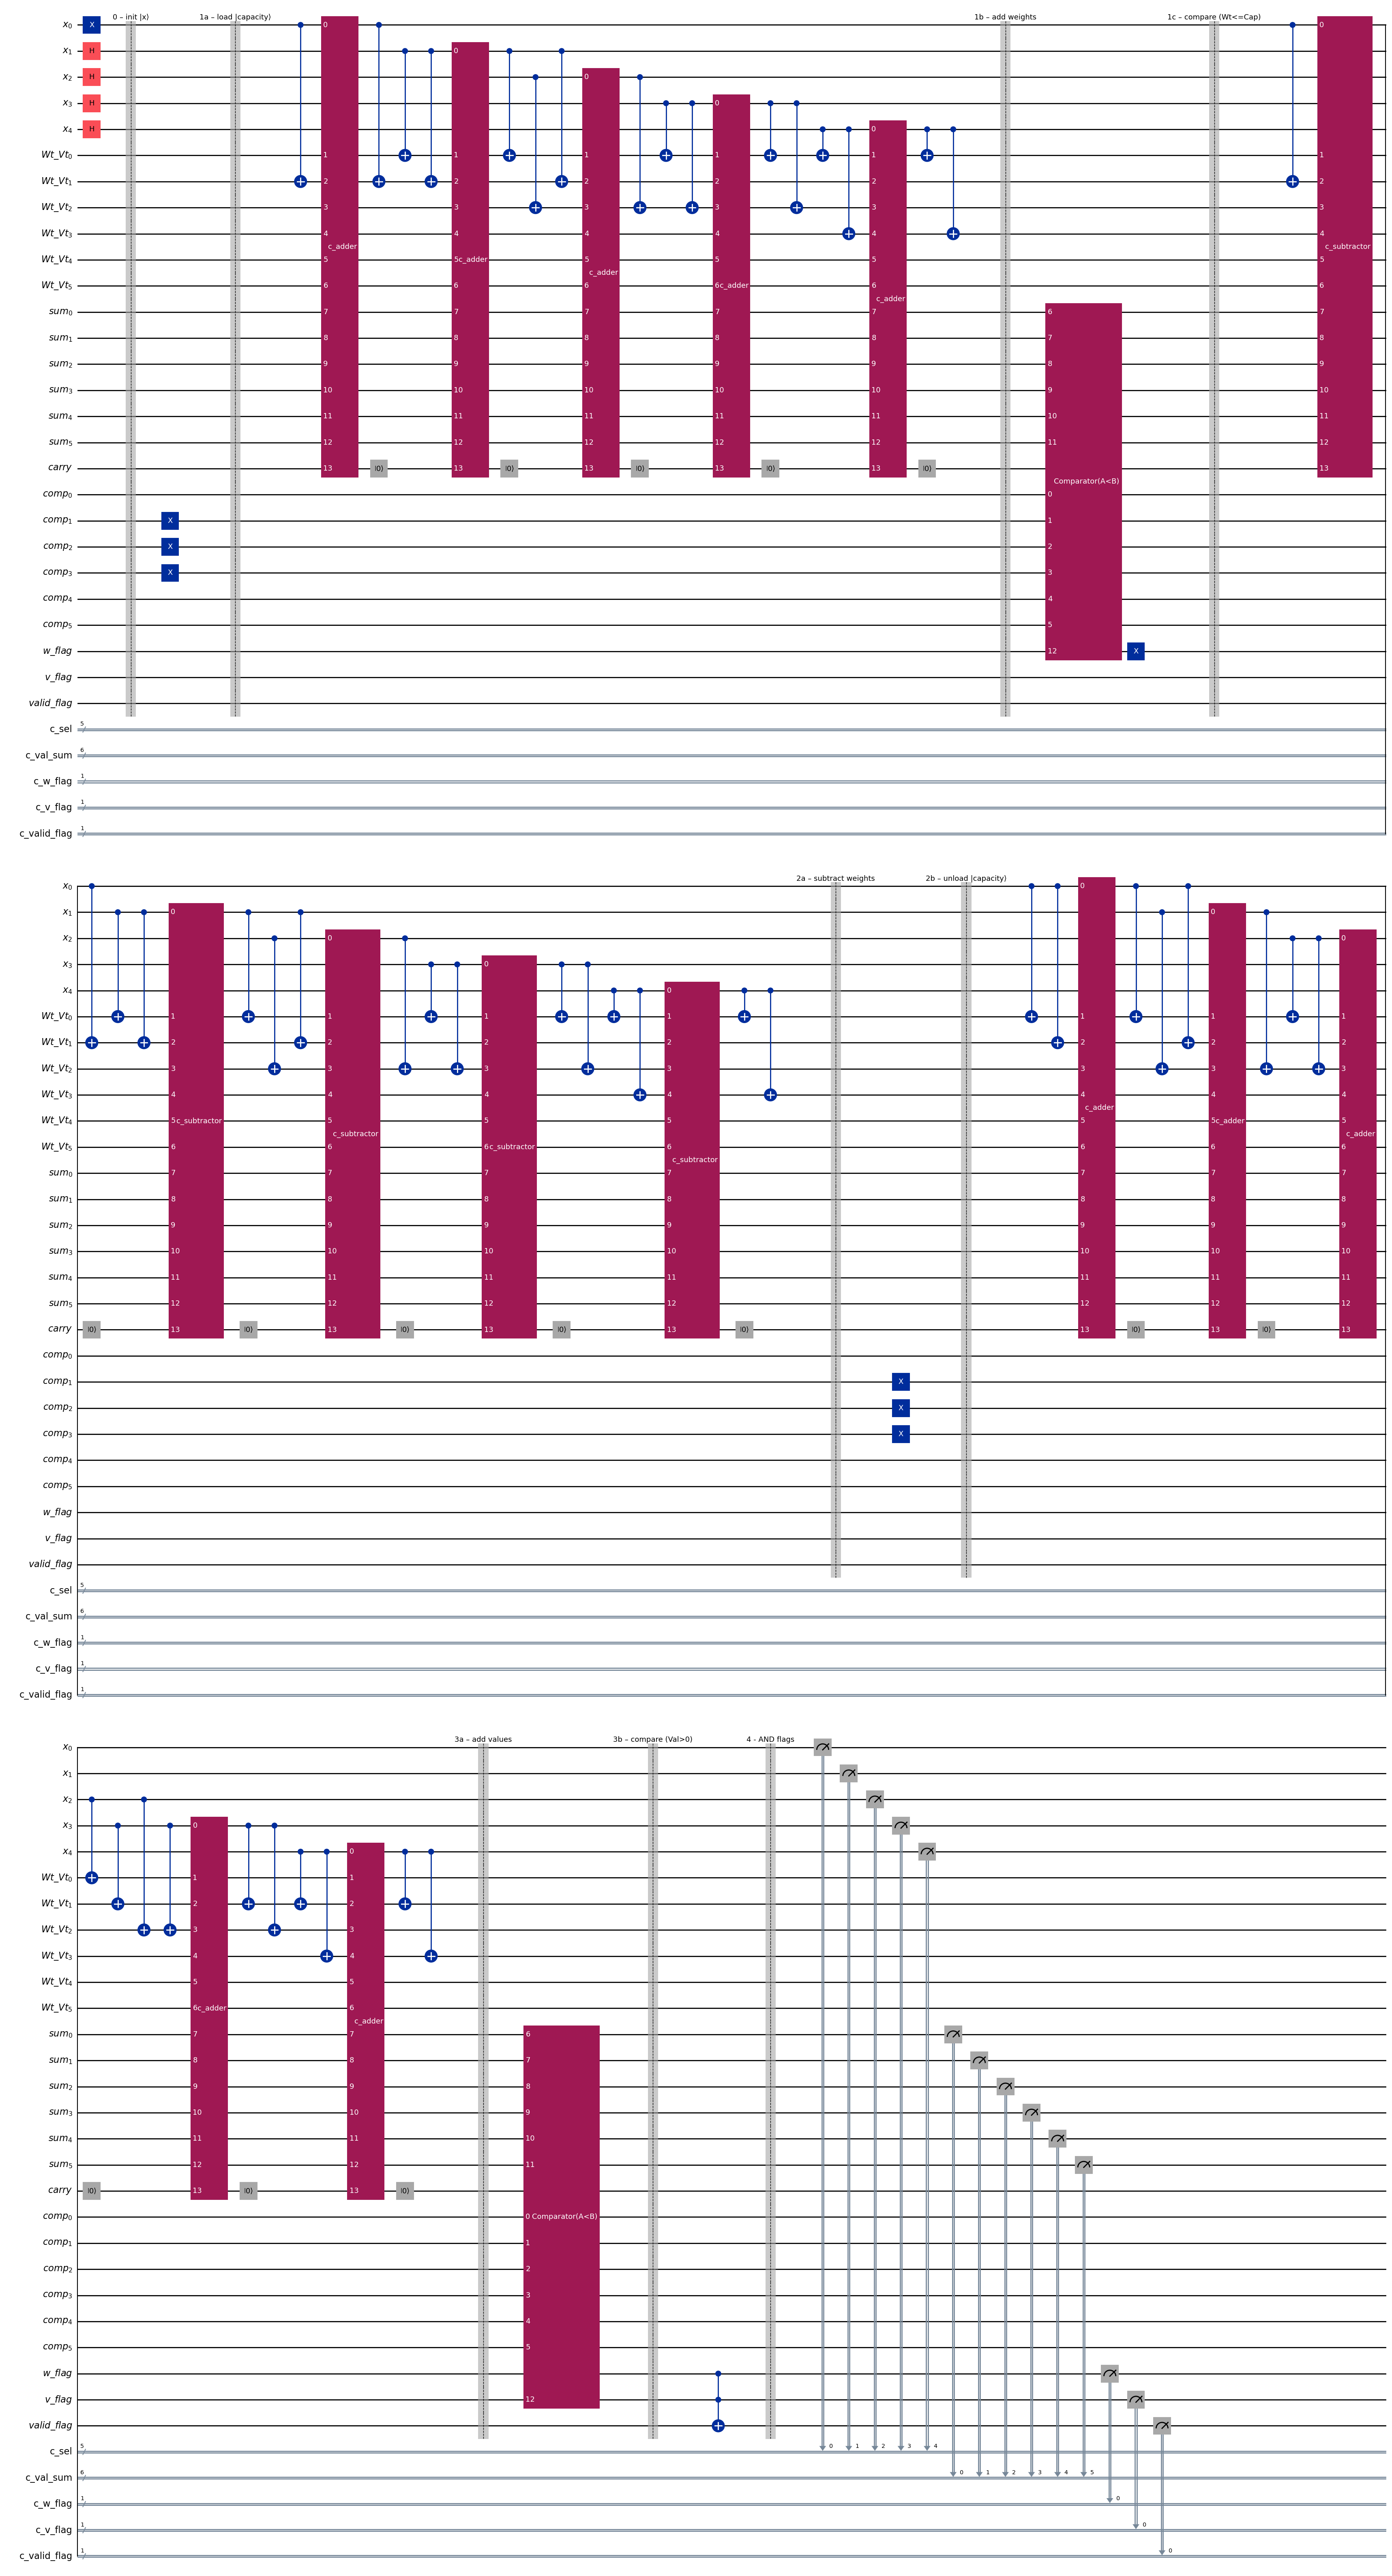

In [5]:
qc.draw(output='mpl', fold=50)